In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from sklearn import preprocessing, ensemble, metrics, linear_model, model_selection, inspection
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from shapely import geometry
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
plt.rc('font', family='Arial', size=12)
plt.rc('lines', linewidth=0.3)

# Plot sample locations

In [3]:
df = pd.read_csv('../datasets/compiled_soc_turnover_sample_data.csv')
print(df.shape)
print(list(df.columns))
print()
print(list(pd.Series(np.unique(df['biome_type_name'])).iloc[[5, 3, 0, 6, 4, 2, 7, 1]]))

biome_name_list = ['Tropical forests', 'Temperate forests', 'Boreal forests', 'Tropical savannahs and grasslands', 'Temperate grasslands and shrublands', 'Deserts', 'Tundra', 'Croplands']

(46237, 7)
['profile_id', 'latitude', 'longitude', 'biome_type', 'biome_type_name', 'tovr_0to30', 'tovr_30to100']

['Tropical forests', 'Temperate forests', 'Boreal forests', 'Tropical savannahs and grasslands', 'Temperate grasslands and shrublands', 'Deserts', 'Tundra', 'Croplands']


C:\Users\LZ\AppData\Local\Temp\ipykernel_28060\4137423569.py:14: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.5)


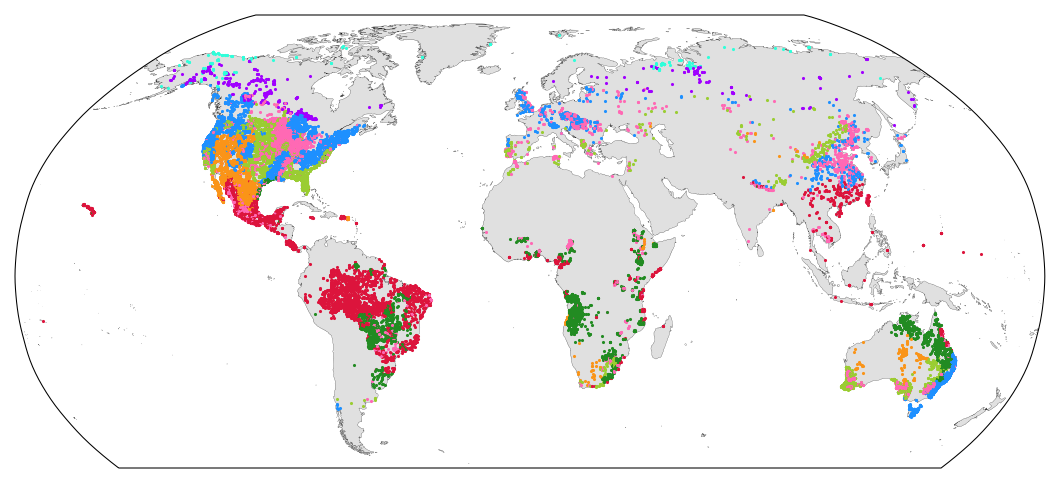

In [4]:
# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)
# cmap = plt.get_cmap('bwr')
# cmap = plt.get_cmap('Accent')
cmap = mpl.colors.ListedColormap(['#DC143C', '#1E90FF', '#A000FF', '#228B22', '#9ACD32', '#FA9418', '#2FFFDA', '#FF69B4'])
color_dict = {'Tropical forests': '#DC143C', 'Temperate forests': '#1E90FF', 'Boreal forests': '#A000FF', 'Tropical savannahs and grasslands': '#228B22',
              'Temperate grasslands and shrublands': '#9ACD32', 'Deserts': '#FA9418', 'Tundra': '#2FFFDA', 'Croplands': '#FF69B4'}

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(9, 4), dpi=150, linewidth=0.5)
ax = plt.axes(projection=crs)
ax.outline_patch.set_linewidth(0.5)

ax.coastlines("50m", color="black", linewidth=0.1)
ax.add_feature(cfeature.LAND, color='#E0E0E0', linewidth=0)

for i in range(len(df)):
    ax.plot(df['longitude'][i], df['latitude'][i], marker='o', markersize=1.5, markeredgecolor='none', markeredgewidth=0, color=color_dict[df['biome_type_name'][i]], transform=ccrs.PlateCarree())

# ax.set_global()
extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent)

# plt.savefig('./figure/sample_locations_robin.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Plot observation vs. prediction

In [5]:
df_obspre = pd.read_csv('../datasets/processed/df_res_samples_obs&pre_top.csv')
# df_obspre = pd.read_csv('../datasets/processed/df_res_samples_obs&pre_sub.csv')

df_obspre['obs'] = np.log10(df_obspre['obs'])
df_obspre['pre'] = np.log10(df_obspre['pre'])

df_obspre_agg = df_obspre.groupby('biome', as_index=False).agg('mean')

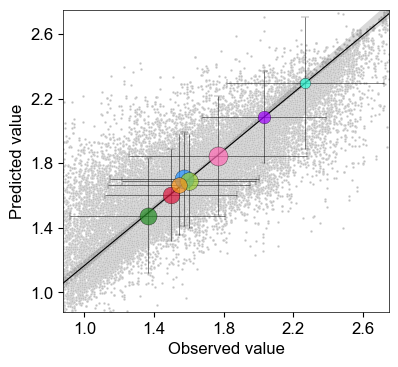

In [6]:
plt.figure(figsize=(4.2, 4), dpi=100)
plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5

v_min = 0.88
v_max = 2.75
ticks = np.arange(1.0, 2.6+0.01, 0.4)

# v_min = 1.2
# v_max = 3.75
# ticks = np.arange(1.2, v_max+0.01, 0.4)

## using values of year
# v_min = 0
# v_max = 250
# ticks = np.arange(v_min, v_max+0.01, 50)

# v_min = 0
# v_max = 5000
# ticks = np.arange(v_min, v_max+0.01, 500)

biome_list = ['Croplands', 'Tropical forests', 'Temperate forests', 'Boreal forests', 'Tropical savannahs and grasslands', 'Temperate grasslands and shrublands', 'Deserts', 'Tundra']
sample_size_list = [13420, 4256, 13512, 563, 4959, 7163, 2333, 186]
color_list = ['#FF69B4', '#DC143C', '#1E90FF', '#A000FF', '#228B22', '#9ACD32', '#FA9418', '#2FFFDA']

sns.scatterplot(x='obs', y='pre', data=df_obspre, marker='o', s=3, color='#C0C0C0')

for i in range(len(biome_list)):
    biome = biome_list[i]
    sample_size = sample_size_list[i]
    df_obspre_onebiome = df_obspre[df_obspre['biome'] == biome].reset_index(drop=True)
    # df_obspre_onebiome = df_obspre_sampled[df_obspre_sampled['biome'] == biome].reset_index(drop=True)
    obs_list = np.array(df_obspre_onebiome['obs'])
    pre_list = np.array(df_obspre_onebiome['pre'])
    xerr = np.std(obs_list)
    yerr = np.std(pre_list)
    
    plt.errorbar(np.mean(obs_list), np.mean(pre_list), xerr=xerr, yerr=yerr,
                 fmt='o', ms=np.log2(sample_size)*1, color=color_list[i], linestyle='-', ecolor='black', elinewidth=0.5, capsize=3, capthick=0.5, barsabove=False,
                 markeredgecolor='black', markeredgewidth=0.3, alpha=0.7,
                 label=biome)

sns.regplot(x='obs', y='pre', data=df_obspre_agg, marker='o', color='black', scatter_kws={'s': 0, 'color': '#E0E0E0'}, line_kws={'linewidth': 0.8}, truncate=False, ci=95)

plt.legend([], [], frameon=False)

plt.xticks(ticks)
plt.yticks(ticks)
plt.xlim(v_min, v_max)
plt.ylim(v_min, v_max)
plt.xlabel('Observed value')
plt.ylabel('Predicted value')

# plt.savefig('./figure/Obs_vs_Pre_biome_level_topsoil.jpg', dpi=600, bbox_inches='tight')
# plt.savefig('./figure/Obs_vs_Pre_biome_level_subsoil.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Plot predicted turnover time maps

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

C:\Users\LZ\AppData\Local\Temp\ipykernel_28060\2292267440.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  map_pred = xr.open_rasterio('../datasets/processed/global_turnover_time_maps/tovr_0to30_mean.tif')
C:\Users\LZ\AppData\Local\Temp\ipykernel_28060\2292267440.py:22: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.5)


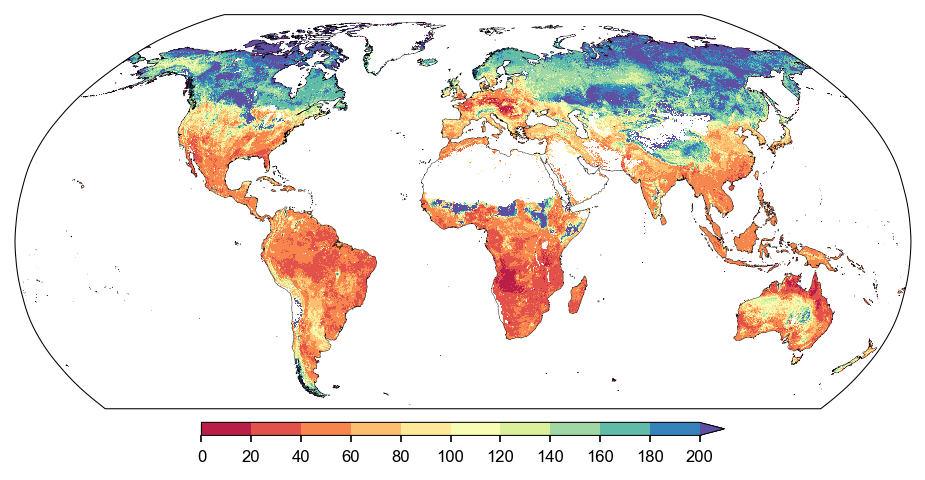

In [8]:
map_pred = xr.open_rasterio('../datasets/processed/global_turnover_time_maps/tovr_0to30_mean.tif')
# map_pred = xr.open_rasterio('../datasets/processed/global_turnover_time_maps/tovr_30to100_mean.tif')
map_pred.close()

vmin = 0
vmax = 200
levels = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

# vmin = 0
# vmax = 3000
# levels = [0, 50, 100, 200, 300, 400, 600, 1000, 1500, 2000, 3000]

# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.3)

fig = plt.figure(figsize=(9, 4), dpi=150, linewidth=0.1, frameon=False)
ax = fig.add_subplot(111, projection=crs)
ax.outline_patch.set_linewidth(0.5)

# ax.add_feature(cfeature.LAND, color='#E0E0E0', linewidth=0)
ax.coastlines("50m", color="black", linewidth=0.2)

norm = mpl.colors.Normalize(vmin, vmax)
cmap = plt.cm.get_cmap('Spectral')
cmap = truncate_colormap(cmap, 0.05, 1)  # use this when ploting subsoil turnover time

im = map_pred[0].plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), levels=levels, add_labels=False, add_colorbar=False)

cb = plt.colorbar(im, orientation="horizontal", fraction=0.1, aspect=40, shrink=0.5, ticks=levels, pad=0.03)
cb.set_label(label='', size=8)
cb.ax.tick_params(labelsize=8)

# ax.set_global()
extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# plt.savefig('./figure/predmap_tovr_topsoil_robin.jpg', dpi=600, bbox_inches='tight')
# plt.savefig('./figure/predmap_tovr_subsoil_robin.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Plot uncertainty maps

## Mapping prediction uncertainty by using QRF

C:\Users\LZ\AppData\Local\Temp\ipykernel_28060\230915237.py:7: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  map_pred = xr.open_rasterio('../datasets/processed/global_turnover_time_maps/pred_map_top_QRF_unc.tif')
C:\Users\LZ\AppData\Local\Temp\ipykernel_28060\230915237.py:36: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.5)


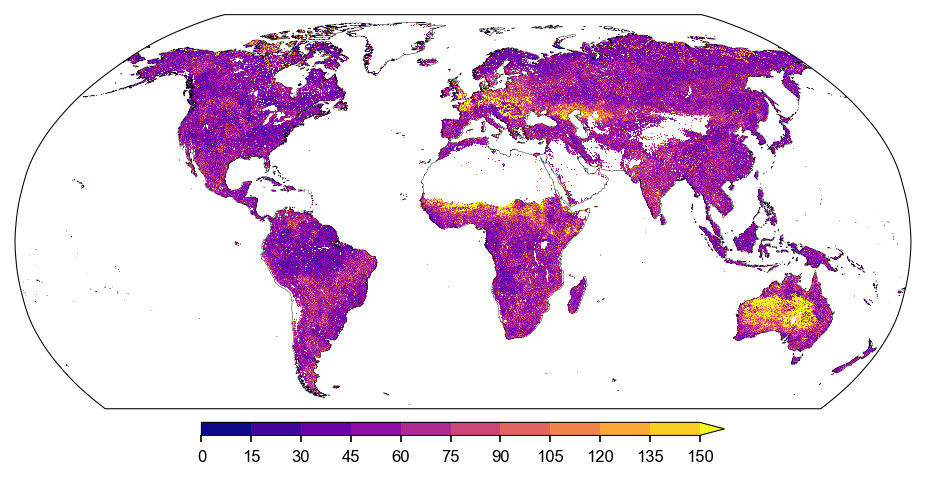

In [9]:
map_pred = xr.open_rasterio('../datasets/processed/global_turnover_time_maps/pred_map_top_QRF_unc.tif')
# map_pred = xr.open_rasterio('../datasets/processed/global_turnover_time_maps/pred_map_sub_QRF_unc.tif')

# mask_npp = gpd.read_file('./data/mask_npp/mask_npp_vector.shp')
# map_pred = map_pred.rio.write_crs('WGS84').rio.clip(mask_npp.geometry)

map_pred.values = 100 * map_pred.values

map_pred.close()

# print(np.nanmin(map_pred.values), np.nanmax(map_pred.values), np.nanmean(map_pred.values), np.nanmedian(map_pred.values))

vmin = 0
vmax = 150
levels = np.arange(vmin, vmax+0.01, 15)

# cmap = plt.cm.get_cmap('viridis')
cmap = plt.cm.get_cmap('plasma')

# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.3)

fig = plt.figure(figsize=(9, 4), dpi=150, linewidth=0.1, frameon=False)
ax = fig.add_subplot(111, projection=crs)
ax.outline_patch.set_linewidth(0.5)

ax.coastlines("50m", color="black", linewidth=0.2)

norm = mpl.colors.Normalize(vmin, vmax)

im = map_pred[0].plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), levels=levels, add_labels=False, add_colorbar=False)

cb = plt.colorbar(im, orientation="horizontal", fraction=0.1, aspect=40, shrink=0.5, pad=0.03, spacing='uniform', ticks=levels)
cb.set_label(label='', size=8)
cb.ax.tick_params(labelsize=8)

# ax.set_global()
extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent)

plt.show()

## Mapping confidence interval by using bootstrap sampling procedure

C:\Users\LZ\AppData\Local\Temp\ipykernel_28060\3090578441.py:7: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  map_pred = xr.open_rasterio('../datasets/processed/global_turnover_time_maps/tovr_0to30_unc.tif')
C:\Users\LZ\AppData\Local\Temp\ipykernel_28060\3090578441.py:38: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.5)


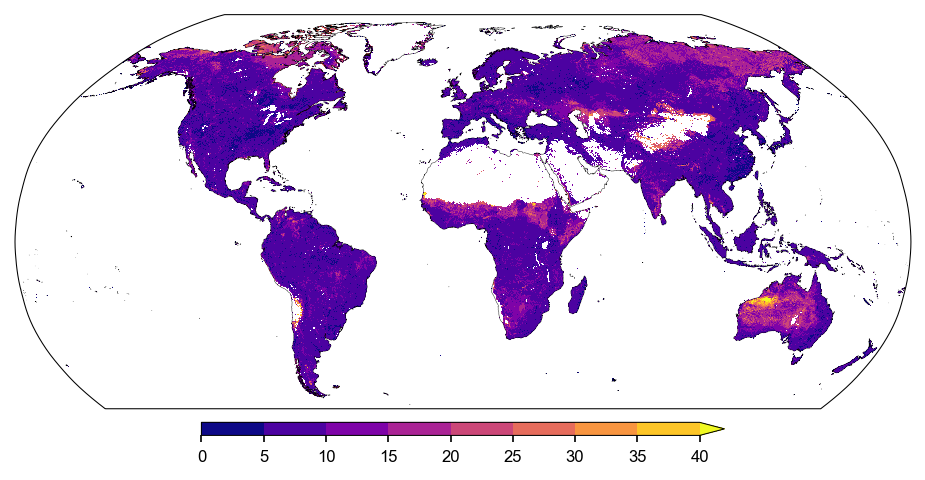

In [10]:
map_pred = xr.open_rasterio('../datasets/processed/global_turnover_time_maps/tovr_0to30_unc.tif')
# map_pred = xr.open_rasterio('../datasets/processed/global_turnover_time_maps/tovr_30to100_unc.tif')

# mask_npp = gpd.read_file('./data/mask_npp/mask_npp_vector.shp')
# map_pred = map_pred.rio.write_crs('WGS84').rio.clip(mask_npp.geometry)

map_pred.values = 100 * map_pred.values
map_pred.close()

# print(np.nanmin(map_pred.values), np.nanmax(map_pred.values), np.nanmean(map_pred.values))

vmin = 0
vmax = 40
levels = np.arange(vmin, vmax+0.01, 5)

# vmin = 0
# vmax = 40
# levels = np.arange(vmin, vmax+0.01, 5)

# cmap = plt.cm.get_cmap('viridis')
cmap = plt.cm.get_cmap('plasma')

# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.3)

fig = plt.figure(figsize=(9, 4), dpi=150, linewidth=0.1, frameon=False)
ax = fig.add_subplot(111, projection=crs)
ax.outline_patch.set_linewidth(0.5)

ax.coastlines("50m", color="black", linewidth=0.2)

norm = mpl.colors.Normalize(vmin, vmax)

im = map_pred[0].plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), levels=levels, add_labels=False, add_colorbar=False)

cb = plt.colorbar(im, orientation="horizontal", fraction=0.1, aspect=40, shrink=0.5, pad=0.03, spacing='proportional', ticks=levels)
cb.set_label(label='', size=8)
cb.ax.tick_params(labelsize=8)

# ax.set_global()
extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent)

# plt.savefig('./figure/uncertainty_tovr_topsoil_robin.jpg', dpi=600, bbox_inches='tight')
# plt.savefig('./figure/uncertainty_tovr_subsoil_robin.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Plot importance map of different categories of covariates

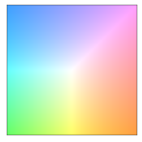

In [11]:
def get_colorTriangle(r, g, b):
    image = np.stack([r, g, b], axis=2)
    return image / image.max(axis=2)[:,:,None]

size = 100
shift = 0.2
X, Y = np.meshgrid(np.linspace(0+shift, 1-shift, size), np.linspace(0+shift, 1-shift, size))
u = np.full_like(X, 0.5)
w = Y
v = X
color_triangle = get_colorTriangle(v, u, w)

plt.figure(figsize=(3, 3), dpi=50)
plt.imshow(color_triangle, origin='lower', extent=(0, 1, 0, 1))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
# plt.savefig('./figure/legend_importance_rgb.jpg', dpi=600)
plt.show()

C:\Users\LZ\AppData\Local\Temp\ipykernel_28060\1242647249.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  I_map_sythesis = xr.open_rasterio('../datasets/processed//I_map_top.tif')
C:\Users\LZ\AppData\Local\Temp\ipykernel_28060\1242647249.py:12: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.5)


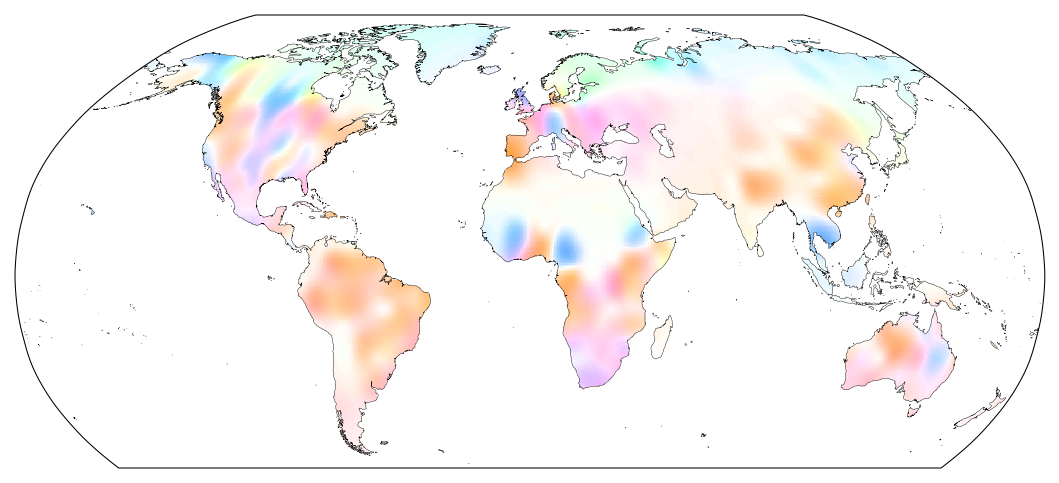

In [12]:
I_map_sythesis = xr.open_rasterio('../datasets/processed//I_map_top.tif')
# I_map_sythesis = xr.open_rasterio('../datasets/processed/I_map_sub.tif')

# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.3)
plt.figure(figsize=(9, 4), dpi=150)
ax = plt.axes(projection=crs)
ax.outline_patch.set_linewidth(0.5)

ax.coastlines("50m", color="black", linewidth=0.2)

# interpolation_methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
extent = [-179.999, 179.999, -60, 90]
I_map_sythesis.plot.imshow(ax=ax, rgb="band", transform=ccrs.PlateCarree(), interpolation='none', add_labels=False, extent=extent)

# ax.set_global()
ax.set_extent(extent)

# plt.savefig('./figure/map_importance_rgb_topsoil_robin.jpg', dpi=600, bbox_inches='tight')
# plt.savefig('./figure/map_importance_rgb_subsoil_robin.jpg', dpi=600, bbox_inches='tight')
plt.show()